In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [16]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

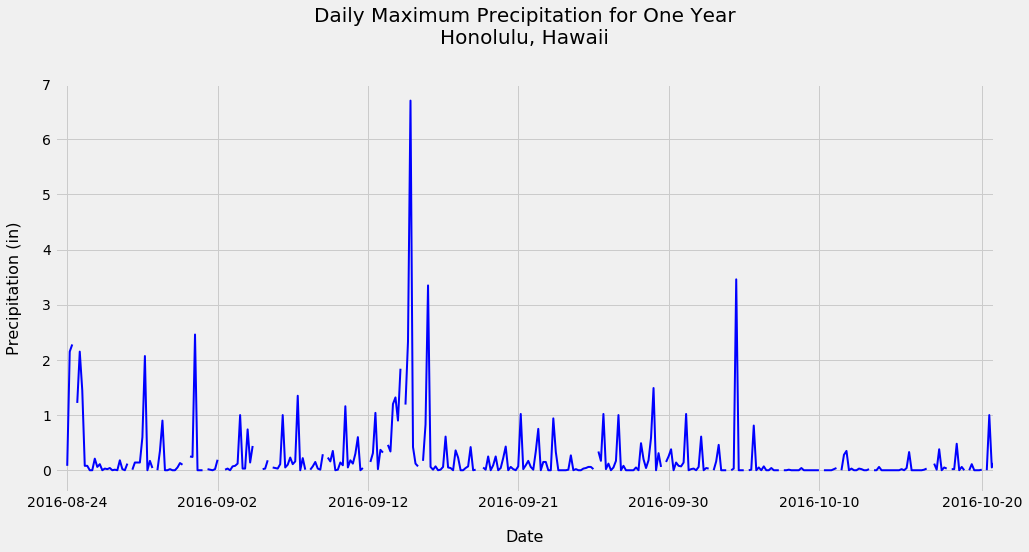

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-24', Measurement.date <= '2017-08-23').\
        order_by(Measurement.date).all()
precip

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(data=precip)
precip_df.head()

# Sort the dataframe by date
precip_df = precip_df.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(15,7)
precip_df.plot(linewidth=2,alpha=1,rot=0, 
             xticks=(0,60,120,180,240,300,365),
             color='blue')

plt.xlim(-5,370)
plt.ylim(-0.4,7)
plt.legend('',frameon=False)
plt.xlabel('Date',fontsize=16,color='black',labelpad=20)
plt.ylabel('Precipitation (in)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Maximum Precipitation for One Year\nHonolulu, Hawaii',fontsize=20,pad=40)

plt.show()

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number stations in the dataset
total_stations=session.query(Station).count()
print(f'There are {total_stations} stations in Honolulu, Hawaii.')

There are 9 stations in Honolulu, Hawaii.


In [39]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_act_stats=(session.query(Measurement.station,func.count(Measurement.station))
                         .group_by(Measurement.station)
                         .order_by(func.count(Measurement.station).desc())
                         .all())
most_act_stats

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sum_tab=[Measurement.station, 
             func.min(Measurement.tobs), 
             func.max(Measurement.tobs), 
             func.avg(Measurement.tobs)]

high_act=(session.query(*sum_tab)
                       .filter(Measurement.station == 'USC00519281')
                       .all())
high_act

high_act_sum=pd.DataFrame(high_act, columns=['station', 'Lowest Temp', 
                                                          'Highest Temp', 'Average Temp'])
high_act_sum.set_index('station', inplace=True)
high_act_sum

,Lowest Temp,Highest Temp,Average Temp
station,,,
USC00519281,54.0,85.0,71.663781


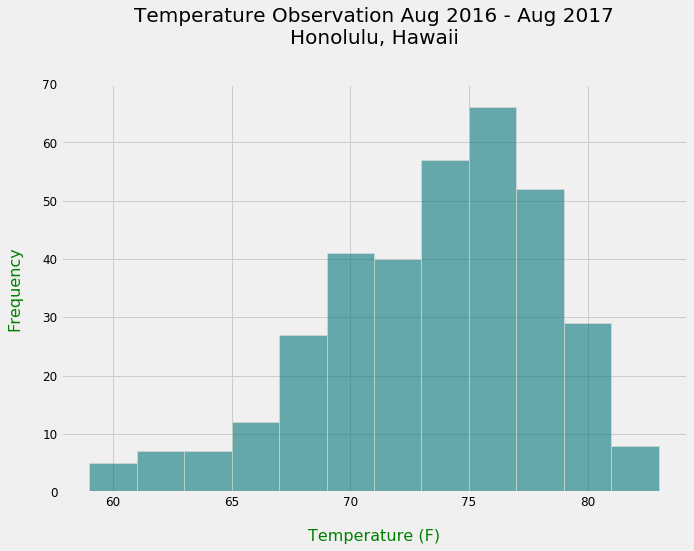

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

USC=(session.query(Measurement.date,(Measurement.tobs))
                  .filter(func.strftime(Measurement.date) > one_year_ago)
                  .filter(Measurement.station=='USC00519281')
                  .all())

df=pd.DataFrame(USC)
df.set_index('date',inplace=True)

plt.rcParams['figure.figsize']=(10,7)
plt.hist(df['tobs'],bins=12,alpha=0.6,edgecolor='xkcd:light gray',
         linewidth=1,color='xkcd:deep aqua')

plt.title('Temperature Observation Aug 2016 - Aug 2017\nHonolulu, Hawaii',fontsize=20,pad=40)
plt.xlabel('Temperature (F)',fontsize=16,color='green',labelpad=20)
plt.ylabel('Frequency',fontsize=16,color='green',labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)

plt.show()

# Close session

In [55]:
# Close Session
session.close()